# Toy data BayesOpt

Running Bayesian optimization algorithm with a toy dataset that has predefined scores for each info architecture.

*Goal:* To test out different hyperparameters for the optimization procedure to see what leads to the cleanest and fastest convergence.

### Contents

1. Building info architectures
2. Setting up BayesOpt
3. Running optimization with different hyperparameters

In [230]:
# Imports
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import interpml as im
from interpml import info_architecture as ia
from interpml import bayes_opt as bo
from interpml import kernels, utils, plotting

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Building info architectures

In [56]:
# Defined by lists of (row1, col1, height, width) tuples
arr1 = [
    (0, 0, 12, 2),
    (0, 2, 4, 10),
    (4, 2, 6, 10),
    (10, 2, 2, 10)
]
arr2 = [
    (0, 0, 2, 5),
    (0, 5, 2, 5),
    (0, 10, 12, 2),
    (2, 0, 6, 5),
    (2, 5, 6, 5),
    (8, 0, 4, 10),
    (0, 10, 12, 2)
]
arr3 = [
    (0, 0, 12, 3),
    (0, 3, 2, 6),
    (2, 3, 8, 6),
    (10, 3, 2, 6),
    (0, 9, 12, 3)
]
arr4 = [
    (0, 0, 7, 12),
    (7, 0, 5, 4),
    (7, 4, 5, 4),
    (7, 8, 5, 4)
]
arr5 = [
    (0, 0, 9, 10),
    (9, 0, 3, 12),
    (0, 10, 3, 2),
    (3, 10, 3, 2),
    (6, 10, 3, 2)
]

In [57]:
treemaps = []
info_archs = []
for i, arch in enumerate([arr1, arr2, arr3, arr4, arr5]):
    for j in range(20):
        arr = ia.spec2arr(arch)
        treemaps.append(arr)
        try:
            info_archs.append(ia.InfoArchTree.from_array(i * 20 + j, arr))
        except:
            pass

In [58]:
len(treemaps)

100

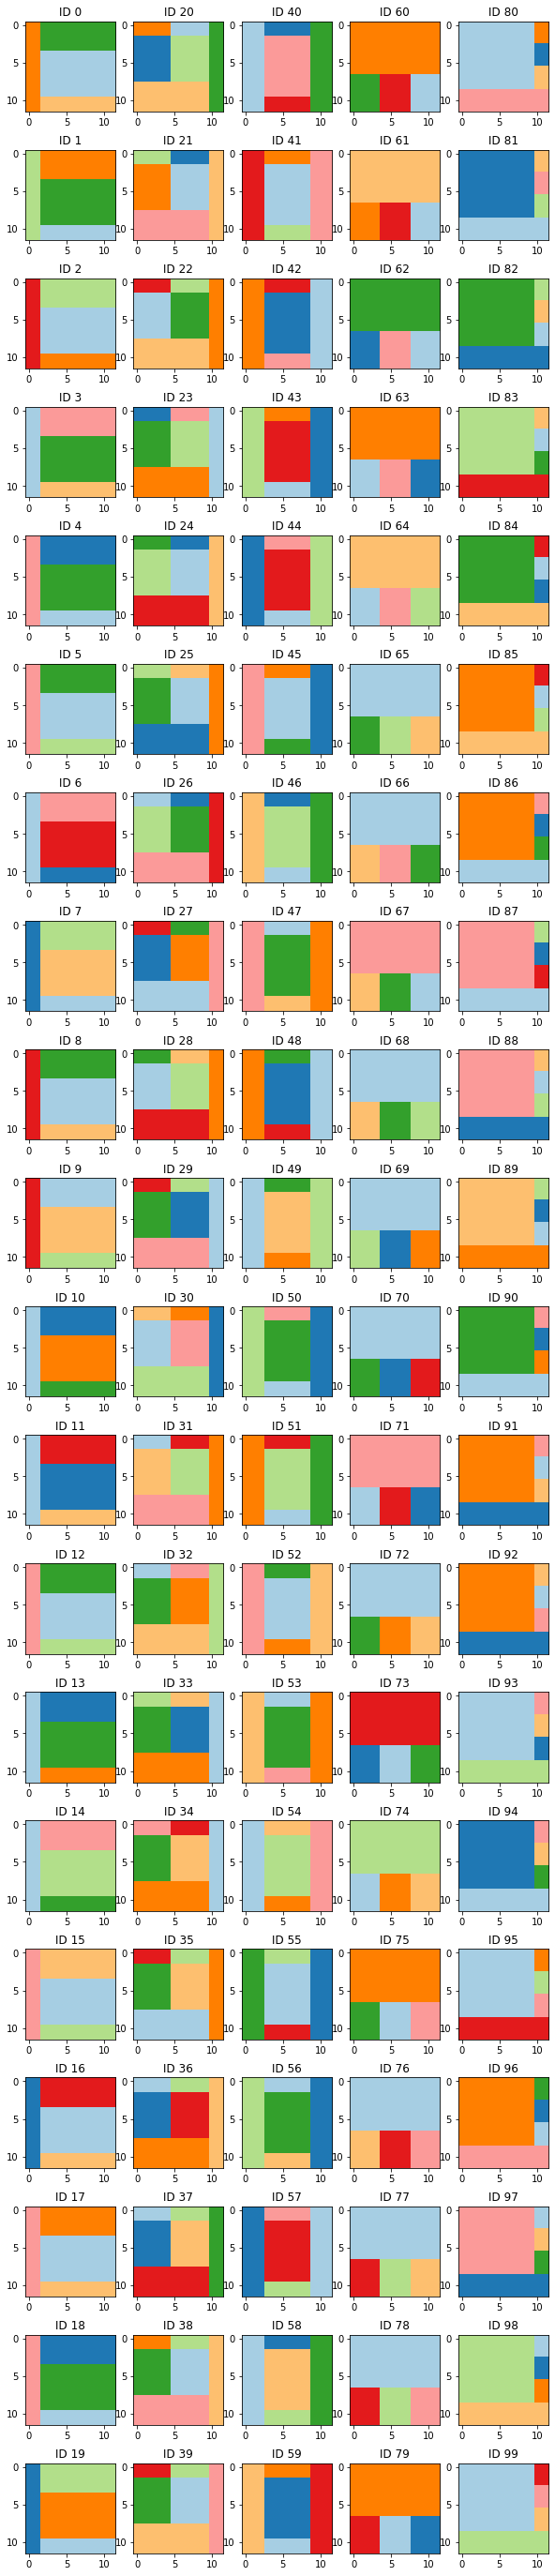

In [59]:
fig, axs = plt.subplots(20, 5, figsize=(5 * 2, 20 * 2.5))
for i, (treemap, ax) in enumerate(zip(treemaps, axs.T.flat)):
    plotting.plot_treemap(treemap, ax=ax)
    ax.set_title(f'ID {i}')

### 2. Setting up BayesOpt

#### 2.1. Defining true preference function

In [89]:
# Defining preference parameters
info_arch_prefs = {
    0: 2,
    1: 1,
    2: 1,
    3: 1,
    4: 2
}
component_prefs = {
    0: 0,
    1: 2,
    2: 3,
    3: 3,
    4: 1,
    5: 1,
    6: 2,
    7: 1,
    8: 1
}

In [90]:
for j, comp in info_archs[0].get_features().iterrows():
    print(comp)

value          8.000000
size           0.166667
orientation    1.000000
depth          0.200000
priority       0.250000
Name: 0, dtype: float64
value          4.000000
size           0.277778
orientation    0.000000
depth          0.400000
priority       0.500000
Name: 1, dtype: float64
value          1.000000
size           0.416667
orientation    0.000000
depth          0.600000
priority       0.750000
Name: 2, dtype: float64
value          7.000000
size           0.138889
orientation    0.000000
depth          1.000000
priority       1.000000
Name: 3, dtype: float64


In [96]:
c_score

0.30000000000000004

In [212]:
y_true = []
for i, infoarch in enumerate(info_archs):
    score = 0.
    ia_idx = np.math.floor(i / 20)
    score += info_arch_prefs[ia_idx]
    for j, comp in infoarch.get_features().iterrows():
        c = int(comp['value'])
        c_score = component_prefs[comp['value']] * comp['size'] * comp['depth'] * 3
        score += c_score
    y_true.append(score)
y_true = np.array(y_true) + np.random.normal(0, .5, size=len(y_true))
y_true = (y_true - y_true.min()) / (y_true - y_true.min()).max()

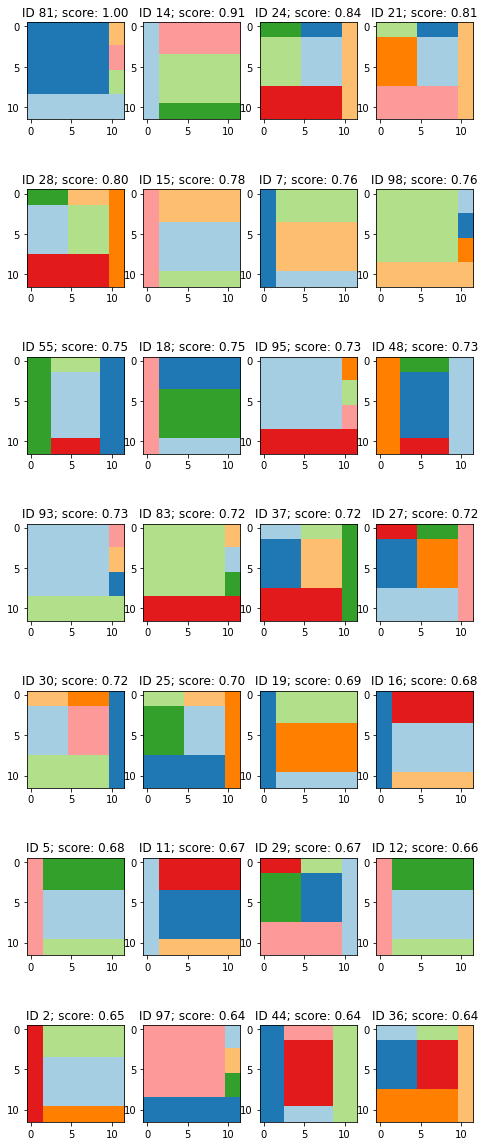

In [214]:
fig, axs = plt.subplots(7, 4, figsize=(4 * 2, 7 * 3))
for idx, ax in zip(np.argsort(y_true)[::-1], axs.flat):
    plotting.plot_treemap(treemaps[idx], ax=ax)
    ax.set_title(f'ID {idx}; score: {y_true[idx]:.2f}')

In [533]:
# weights = np.array([2, .5, 1, 1])
weights=None
X = np.vstack([infoarch.get_feature_vector(components=8) for infoarch in info_archs])

In [534]:
X.shape

(100, 32)

#### 2.2. Initializing hyperparameters of BayesOpt

In [540]:
idx_init = np.random.choice(len(info_archs))
# idx_init = 39
print(idx_init)

74


In [544]:
sigma = 1
length_scale = 3
n_restarts = 10
bayes_opt = bo.BayesianOptimizer(sigma=sigma, kernel='rbf',
                                 acquisition_fn='lcb',
                                 xi=1e-2, kappa=1,
                                 nu=1.5, length_scale=length_scale,
                                 n_restarts=n_restarts)

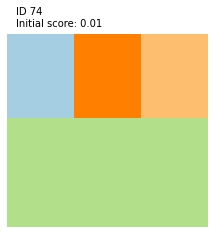

Iter 0


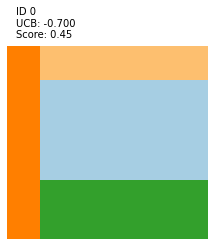

Iter 1


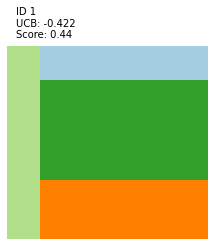

Iter 2


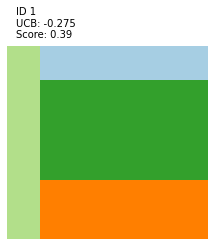

Iter 3


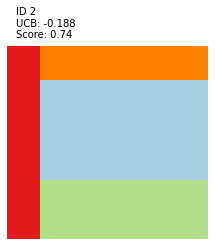

Iter 4


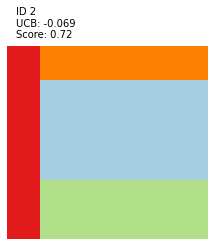

Iter 5


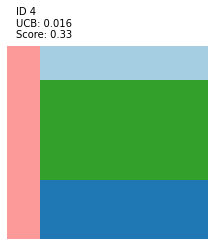

Iter 6


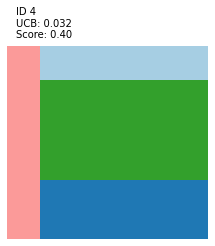

Iter 7


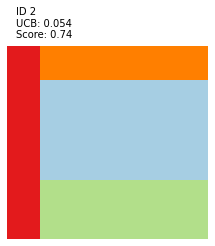

Iter 8


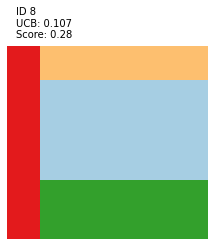

Iter 9


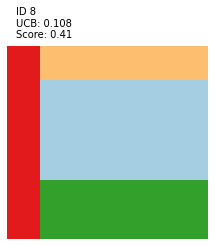

Iter 10


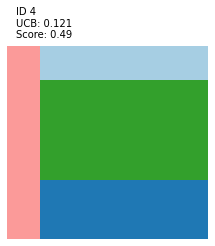

Iter 11


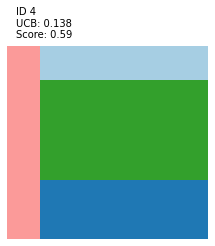

Iter 12


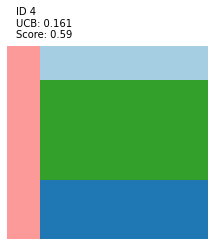

Iter 13


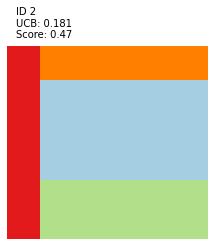

Iter 14


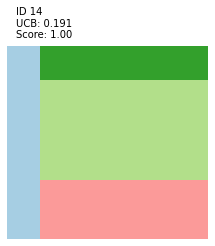

Iter 15


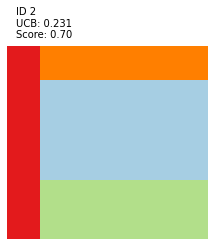

Iter 16


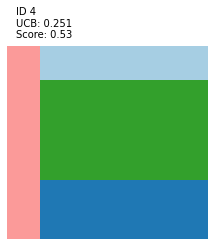

Iter 17


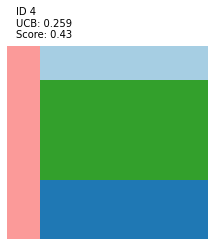

Iter 18


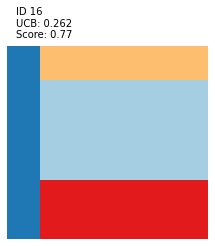

Iter 19


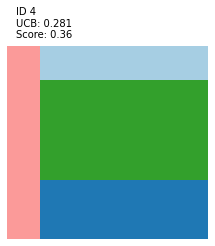

Iter 20


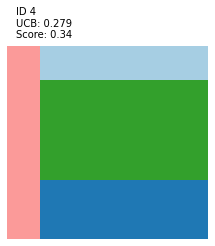

Iter 21


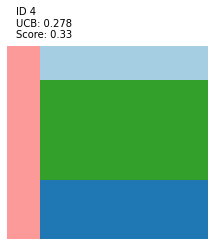

Iter 22


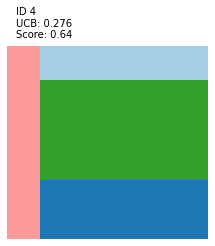

Iter 23


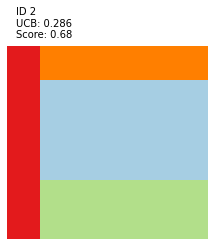

Iter 24


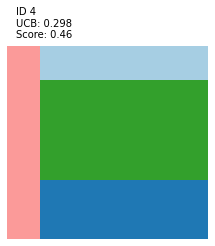

Iter 25


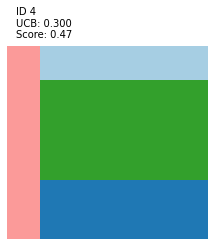

Iter 26


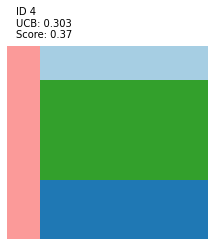

Iter 27


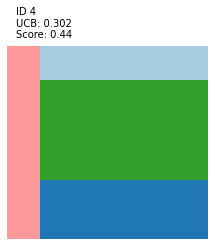

Iter 28


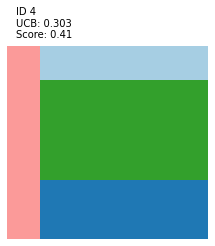

Iter 29


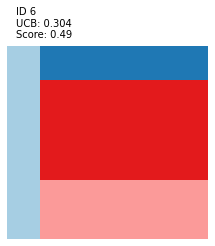

Iter 30


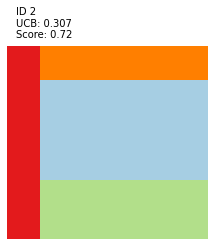

Iter 31


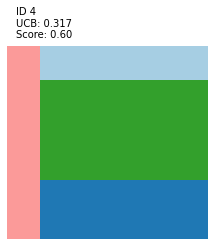

Iter 32


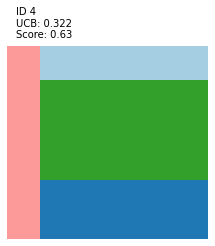

Iter 33


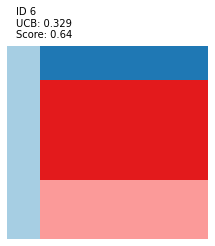

Iter 34


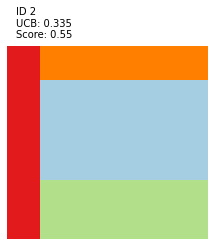

Iter 35


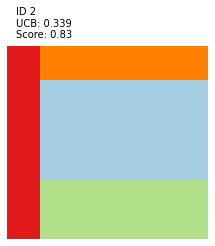

Iter 36


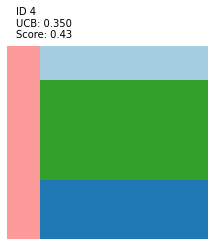

Iter 37


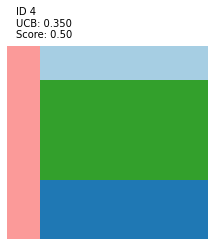

Iter 38


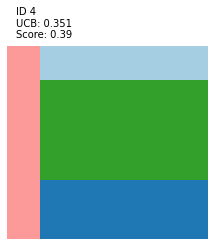

Iter 39


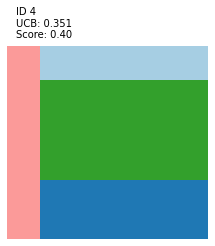

Best Architecture:


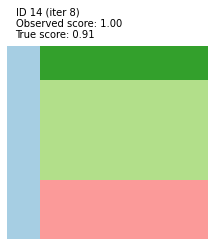

In [545]:
n_iter = 40
sigma_obs = .1

X_samp = X[idx_init]
y_samp = y_true[idx_init]

idx_history = []
y_history = []
score_history = []

plotting.plot_treemap(treemaps[idx_init])
plt.axis('off')
plt.ylim(0, 13)
plt.text(0, 12, f'ID {idx_init}\nInitial score: {y_samp:.2f}')
plt.show()

for i in range(n_iter):
    print(f'Iter {i}')
    bayes_opt.update(X_samp, y_samp)
    idx_next, X_next, score_next = bayes_opt.propose_next(X)
    y_next = y_true[idx_next] + np.random.randn(1) * sigma_obs
    y_next = np.clip(y_next[0], 0, 1)
    
    idx_history.append(idx_next)
    y_history.append(y_next)
    score_history.append(score_next)
    
    X_samp, y_samp = X_next, y_next
    
    plotting.plot_treemap(treemaps[idx_next])
    plt.axis('off')
    plt.ylim(0, 13)
    plt.text(0, 12, f'ID {idx_next}\nUCB: {score_next[0]:.3f}\nScore: {y_next:.2f}')
    plt.show()

print('Best Architecture:')
y_best = 0.
idx_best = None
for idx in set(idx_history):
    candidate_score = np.array(y_history)[idx_history == idx].mean()
    if candidate_score > y_best:
        y_best = candidate_score
        idx_best = idx

plotting.plot_treemap(treemaps[idx_best])
plt.axis('off')
plt.ylim(0, 13)
plt.text(0, 12, f'ID {idx_best} (iter {iter_best})\nObserved score: {y_best:.2f}\nTrue score: {y_true[idx_best]:.2f}')
plt.show()

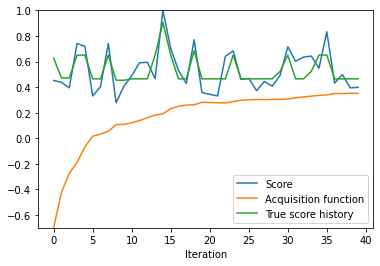

In [546]:
plt.plot(y_history, label='Score')
plt.plot(score_history, label='Acquisition function')
plt.plot([y_true[idx] for idx in idx_history], label='True score history')
plt.xlabel("Iteration")
plt.ylim(min(score_history), 1)
plt.legend();

### Notes

* Optimization is _very_ sensitive to the starting point
    * It is especially tricky with some of the architectures but not all
    * Maybe worth restricting to 2 or 3 different architectures
* Between EI and LCB one does not always outperform the other
    * Generally, LCB has less volatility, which might not necessarily be a good thing
* If it's failing to converge on a reasonably good optimum, increasing sigma is a good bet
* Keep kappa relatively high (for LCB)
* Less sensitive to xi (for EI) although should keep xi relatively low
* Can't tolerate too much noise
    * Gaussian noise with standard deviation of .1 is already quite tough
    * .2 makes it very difficult
    * Note that the scores are normalized between 0 and 1
* Tried Matern, but RBF seems just as good with less parameters